## CIFAR 10 Gray Finetuning


In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import glob
from pathlib import Path
%matplotlib inline

In [2]:
ls datasets/cifar-10-batches-bin/

batches.meta.txt  data_batch_2.bin  data_batch_4.bin  readme.html
data_batch_1.bin  data_batch_3.bin  data_batch_5.bin  test_batch.bin


In [3]:
file_path = "datasets/cifar-10-batches-bin/data_batch_*"
train_bins = glob.glob(file_path)
train_bins

['datasets/cifar-10-batches-bin/data_batch_1.bin',
 'datasets/cifar-10-batches-bin/data_batch_5.bin',
 'datasets/cifar-10-batches-bin/data_batch_3.bin',
 'datasets/cifar-10-batches-bin/data_batch_2.bin',
 'datasets/cifar-10-batches-bin/data_batch_4.bin']

### CIFAR binary format

```bash
<1 byte x label><3*32*32 bytes x pixel>
...
<1 byte x label><3*32*32 bytes x pixel>
```
Each image is represented in **(C,H,W)** format

In [4]:
ft = Path(train_bins[0]).open('rb')
lbl = np.frombuffer(ft.read(1),np.dtype('u1'))
print(lbl)
img = np.frombuffer(ft.read(3*32*32),np.dtype('u1')).reshape(3,32,32)
img = np.transpose(img,(1,2,0))
print(img.shape)

[6]
(32, 32, 3)


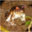

In [5]:
Image.fromarray(img)

[9]


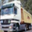

In [6]:
lbl = np.frombuffer(ft.read(1),np.dtype('u1'))
img = np.frombuffer(ft.read(32*32*3),np.dtype('u1')).reshape(3,32,32)
img = np.transpose(img,(1,2,0))
print(lbl)
Image.fromarray(img)

### CIFAR 10 dataset pipeline

In [7]:
def cifar_dataset(files_list:list) -> tf.data.Dataset:

    data = tf.data.FixedLengthRecordDataset(files_list,1+3*32*32)
    data = data.map(lambda x: tf.decode_raw(x,tf.uint8),num_parallel_calls=4)
    data = data.map(lambda x: (x[1:],tf.expand_dims(x[0],0)),num_parallel_calls=4) #To match with MNIST
    data = data.map(lambda x,y: (tf.reshape(x,(3,32,32)),y),num_parallel_calls=4)
    data = data.map(lambda x,y: (tf.transpose(x,(1,2,0)),y),num_parallel_calls=4)
    data = data.map(lambda x,y: (tf.image.rgb_to_grayscale(x),y),num_parallel_calls=4)
    data = data.map(lambda x,y: (tf.image.convert_image_dtype(x,tf.float32),y),num_parallel_calls=4)
        
    return data

In [8]:
with tf.device('/cpu:0'):
    train_dataset = cifar_dataset(train_bins)
    train_dataset = train_dataset.shuffle(20000)
    train_dataset = train_dataset.repeat(20)
    train_dataset = train_dataset.batch(10)
    train_dataset = train_dataset.prefetch(2)

In [9]:
train_dataset.output_shapes, train_dataset.output_types

((TensorShape([Dimension(None), Dimension(32), Dimension(32), Dimension(1)]),
  TensorShape([Dimension(None), Dimension(1)])),
 (tf.float32, tf.uint8))

In [10]:
train_iterator = train_dataset.make_initializable_iterator()

**Check** (Restart kernel and dont call this check before training)

In [12]:
im,l = train_iterator.get_next()

with tf.Session() as sess:
    sess.run(train_iterator.initializer)
    imr,lr = sess.run([im,l])

In [13]:
lr

array([[4],
       [8],
       [1],
       [6],
       [1],
       [5],
       [6],
       [3],
       [8],
       [4]], dtype=uint8)

In [13]:
imr.shape

(10, 32, 32, 1)

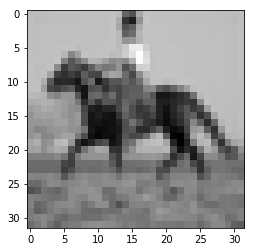

In [14]:
plt.imshow(imr[0].reshape(32,32),cmap='gray')

### Inspect model file

In [11]:
from tensorflow.python.tools import inspect_checkpoint as chkp

In [12]:
chkp.print_tensors_in_checkpoint_file('models/MNIST_CNN/mnist_model.ckpt',tensor_name='', all_tensors=False,all_tensor_names=True)

tensor_name:  Conv1/bias
tensor_name:  Conv1/kernel
tensor_name:  Conv2/bias
tensor_name:  Conv2/kernel
tensor_name:  Conv3/bias
tensor_name:  Conv3/kernel
tensor_name:  Dense_10/bias
tensor_name:  Dense_10/kernel
tensor_name:  Dense_84/bias
tensor_name:  Dense_84/kernel


### Load graph

> Calling **import_meta_data** adds all the variables to the default graph

In [13]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)

[]

In [14]:
saver = tf.train.import_meta_graph('models/MNIST_CNN/mnist_model.ckpt.meta')

In [15]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)

[<tf.Variable 'Conv1/kernel:0' shape=(5, 5, 1, 6) dtype=float32_ref>,
 <tf.Variable 'Conv1/bias:0' shape=(6,) dtype=float32_ref>,
 <tf.Variable 'Conv2/kernel:0' shape=(5, 5, 6, 16) dtype=float32_ref>,
 <tf.Variable 'Conv2/bias:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'Conv3/kernel:0' shape=(5, 5, 16, 120) dtype=float32_ref>,
 <tf.Variable 'Conv3/bias:0' shape=(120,) dtype=float32_ref>,
 <tf.Variable 'Dense_84/kernel:0' shape=(120, 84) dtype=float32_ref>,
 <tf.Variable 'Dense_84/bias:0' shape=(84,) dtype=float32_ref>,
 <tf.Variable 'Dense_10/kernel:0' shape=(84, 10) dtype=float32_ref>,
 <tf.Variable 'Dense_10/bias:0' shape=(10,) dtype=float32_ref>]

**Check**

In [16]:
with tf.Session() as sess:
    #saver.restore(sess,tf.train.latest_checkpoint('models/MNIST_CNN/'))
    print(sess.graph.get_all_collection_keys())
    print(sess.graph.get_collection('classifier'))
    print(sess.graph.get_collection('data_handle'))    

['classifier', 'model_input', 'loss', 'variables', 'data_handle', 'target', 'train', 'train_op', 'trainable_variables', 'iterators']
[<tf.Tensor 'Dense_10/BiasAdd:0' shape=(?, 10) dtype=float32>]
[<tf.Tensor 'Placeholder:0' shape=() dtype=string>]


**Check loading** 

In [17]:
with tf.Session() as sess:
    saver.restore(sess,tf.train.latest_checkpoint('models/MNIST_CNN/'))
    sess.run(train_iterator.initializer)
    hdl = sess.run(train_iterator.string_handle())
    out = sess.run(sess.graph.get_collection('classifier')[0],{sess.graph.get_collection('data_handle')[0]:hdl})

INFO:tensorflow:Restoring parameters from models/MNIST_CNN/mnist_model.ckpt


In [18]:
out

array([[  2.0189478 ,  -4.2664776 ,   3.5971777 ,   1.1141664 ,
         -2.367669  ,  -5.1707683 ,  -0.50807637,  -5.4258213 ,
         10.6410055 ,   1.9788061 ],
       [  2.525255  ,  -4.3408823 ,  -0.8567331 ,   1.416412  ,
         -5.978265  ,   5.3786383 ,   1.6240177 ,  -9.845654  ,
          6.0208855 ,   1.4002415 ],
       [  2.4485016 ,  -5.0073833 ,  -1.1253401 ,   2.2328122 ,
         -2.3208823 ,  -0.5262407 ,  -0.8510316 ,  -9.240399  ,
         11.391828  ,   2.8907218 ],
       [  0.2218481 ,  -3.2344196 ,   0.5811044 ,  -1.1239905 ,
         -0.5756186 ,   2.7580996 ,   7.7709365 , -13.409174  ,
          7.724094  ,  -2.4644518 ],
       [  7.118596  ,  -4.057072  ,   5.0432315 ,   0.60894734,
         -3.9047565 ,  -0.9013839 ,   1.5265572 ,  -7.388623  ,
          6.8964763 ,  -3.3079648 ],
       [  4.3943677 ,  -4.572311  ,   1.7764732 ,   0.7551139 ,
         -2.4600933 ,  -1.2062032 ,   2.5403178 , -10.603845  ,
          9.449195  ,  -0.40938628],
       [  

### Finetune

In [19]:
!rm models/CIFAR10_grey/*

In [20]:
import time

#Its better to use new saver, esp when you have created new tensors in this code
saver_train = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess,tf.train.latest_checkpoint('models/MNIST_CNN/'))
    sess.run(train_iterator.initializer)
    hdl = sess.run(train_iterator.string_handle())
    
    loss = sess.graph.get_collection('loss')[0]
    train = sess.graph.get_collection('train')[0]
    handle = sess.graph.get_collection('data_handle')[0]


    start = time.time()
    try:
        i = 1
        tmp = []
        while True:
            i = i+1
            l,_ = sess.run([loss,train],{handle:hdl})
            tmp.append(l)
            if i%5000 == 0:
                avg_loss = np.array(tmp).mean()
                print("Batch: ",i,avg_loss)
                tmp = []
                
    except tf.errors.OutOfRangeError:
        pass
    
    end = time.time()
    elapsed = end-start
    print("Elapsed time : ", elapsed, " s")
    
    
    saver_train.save(sess,'models/CIFAR10_grey/cifar_model.ckpt')

INFO:tensorflow:Restoring parameters from models/MNIST_CNN/mnist_model.ckpt
Batch:  5000 2.0001802
Batch:  10000 1.7430707
Batch:  15000 1.6396687
Batch:  20000 1.5670671
Batch:  25000 1.5099636
Batch:  30000 1.462484
Batch:  35000 1.4191142
Batch:  40000 1.3841664
Batch:  45000 1.3517032
Batch:  50000 1.3213867
Batch:  55000 1.2926822
Batch:  60000 1.2687166
Batch:  65000 1.2451665
Batch:  70000 1.2203715
Batch:  75000 1.1963223
Batch:  80000 1.1746683
Batch:  85000 1.1517882
Batch:  90000 1.1321872
Batch:  95000 1.1118125
Batch:  100000 1.0920491
Elapsed time :  129.30929350852966  s


### Evaluate

In [21]:
with tf.device('/cpu:0'):
    test_dataset = cifar_dataset(['datasets/cifar-10-batches-bin/test_batch.bin'])
    test_dataset = test_dataset.batch(10)
    test_dataset = test_dataset.prefetch(2)
    
test_iterator = test_dataset.make_initializable_iterator()

In [22]:
def get_accuracy(predict:'eg: [2,4,1,...]',true: 'eg: [2,4,1,...]') -> int:
    correct_pred = tf.equal(predict,true)
    #We have to cast [True,False,True,...] --> [1,0,1...]
    acc = tf.reduce_mean(tf.cast(correct_pred,tf.float32))
    return acc


with tf.Session() as sess:

    saver_train.restore(sess,'models/CIFAR10_grey/cifar_model.ckpt')
    sess.run(test_iterator.initializer)
    hdl = sess.run(test_iterator.string_handle())

    
    label = sess.graph.get_collection('target')[0]
    classifier = sess.graph.get_collection('classifier')[0]
    handle = sess.graph.get_collection('data_handle')[0]
    
    #IMPORTANT:
    #Dont place this code inside the loop! This will slow down everything
    acc = get_accuracy(tf.argmax(classifier,axis=1),tf.transpose(tf.argmax(tf.one_hot(label,10),axis=2)))
    
    try:
        i = 0
        acc_list = []
        while True:
            i = i+1
            a = sess.run(acc,{handle:hdl})
            acc_list.append(a)
            if i%100 == 0:
                print(i, "Mean Acc : ", np.array(acc_list).mean())
                acc_list = []
                           
    except tf.errors.OutOfRangeError:
        pass    

INFO:tensorflow:Restoring parameters from models/CIFAR10_grey/cifar_model.ckpt
100 Mean Acc :  0.53099996
200 Mean Acc :  0.535
300 Mean Acc :  0.51500005
400 Mean Acc :  0.536
500 Mean Acc :  0.546
600 Mean Acc :  0.55
700 Mean Acc :  0.525
800 Mean Acc :  0.53400004
900 Mean Acc :  0.50499994
1000 Mean Acc :  0.523


### Training LeNET from scratch (Not much difference)

> Just add **tf.global_variable_initializer** to the previous code

In [23]:
!rm models/CIFAR10_grey/*

In [26]:
import time
#saver = tf.train.import_meta_graph('models/MNIST_CNN/mnist_model.ckpt.meta')


with tf.Session() as sess:
    saver.restore(sess,tf.train.latest_checkpoint('models/MNIST_CNN/'))
    sess.run(tf.global_variables_initializer()) 
    sess.run(train_iterator.initializer)
    hdl = sess.run(train_iterator.string_handle())
    
    loss = sess.graph.get_collection('loss')[0]
    train = sess.graph.get_collection('train')[0]
    handle = sess.graph.get_collection('data_handle')[0]


    start = time.time()
    try:
        i = 1
        tmp = []
        while True:
            i = i+1
            l,_ = sess.run([loss,train],{handle:hdl})
            tmp.append(l)
            if i%5000 == 0:
                avg_loss = np.array(tmp).mean()
                print("Batch: ",i,avg_loss)
                tmp = []
                
    except tf.errors.OutOfRangeError:
        pass
    
    end = time.time()
    elapsed = end-start
    print("Elapsed time : ", elapsed, " s")
    
    
    saver.save(sess,'models/CIFAR10_grey/cifar_model.ckpt')

INFO:tensorflow:Restoring parameters from models/MNIST_CNN/mnist_model.ckpt
Batch:  5000 2.0937455
Batch:  10000 1.8949004
Batch:  15000 1.7356673
Batch:  20000 1.648246
Batch:  25000 1.5810332
Batch:  30000 1.5213076
Batch:  35000 1.4676836
Batch:  40000 1.4214152
Batch:  45000 1.3797578
Batch:  50000 1.3418465
Batch:  55000 1.3089824
Batch:  60000 1.2737926
Batch:  65000 1.2469199
Batch:  70000 1.2171801
Batch:  75000 1.1889061
Batch:  80000 1.1639483
Batch:  85000 1.1366851
Batch:  90000 1.1154944
Batch:  95000 1.0912582
Batch:  100000 1.0679497
Elapsed time :  131.02445888519287  s


### Evaluate

In [27]:
with tf.Session() as sess:
    saver.restore(sess,'models/CIFAR10_grey/cifar_model.ckpt')
    #sess.run(tf.global_variables_initializer()) #0.01 acc for non trained model
    sess.run(test_iterator.initializer)
    hdl = sess.run(test_iterator.string_handle())
    
    label = sess.graph.get_collection('target')[0]
    classifier = sess.graph.get_collection('classifier')[0]
    
    #IMPORTANT:
    #Dont place this code inside the loop! This will slow down everything
    acc = get_accuracy(tf.argmax(classifier,axis=1),tf.transpose(tf.argmax(tf.one_hot(label,10),axis=2)))
    
    try:
        i = 0
        acc_list = []
        while True:
            i = i+1
            a = sess.run(acc,{handle:hdl})
            acc_list.append(a)
            if i%100 == 0:
                print(i, "Mean Acc : ", np.array(acc_list).mean())
                acc_list = []
                           
    except tf.errors.OutOfRangeError:
        pass    

INFO:tensorflow:Restoring parameters from models/CIFAR10_grey/cifar_model.ckpt
100 Mean Acc :  0.543
200 Mean Acc :  0.523
300 Mean Acc :  0.53199995
400 Mean Acc :  0.536
500 Mean Acc :  0.56399995
600 Mean Acc :  0.515
700 Mean Acc :  0.49300003
800 Mean Acc :  0.53999996
900 Mean Acc :  0.51
1000 Mean Acc :  0.52900004


## Summary

**IMPORTANT**: 

> 1) Do not call **get_next** of any child iterators, when using **feedable iterators**. Make sure they are not called before taining

> 2) Calling **import_meta_data** adds all the variables to the default graph